<a href="https://colab.research.google.com/github/iamdsc/text_biasness_detection/blob/master/text_biasness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install allennlp

In [0]:
pip install flair

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras import initializers, regularizers, constraints
import keras.layers as layers
from keras.models import Model, Sequential, load_model
from keras.engine.topology import Layer
from flair.data import Sentence
from flair.embeddings import ELMoEmbeddings

Using TensorFlow backend.


In [0]:
# Reading in the data from text files
def read_data_from_txt(filename, label):
  data = {}
  data['sentence'] = []
  data['label'] = []
  with open(filename, 'r') as f:
    for line in f:
      data['sentence'].append(line)
      data['label'].append(label)

  data_df = pd.DataFrame(data)
  return data_df

In [3]:
biased_data = read_data_from_txt('biased.txt', 1)
biased_data.head()

,sentence,label
0,"David J. Hanson Ph.D., Professor Emeritus of S...",1
1,While he continually puts forth these findings...,1
2,"According to the Iranian government, the shoot...",1
3,Games revolving around the kicking of a ball t...,1
4,"Irgun, shorthand for Irgun Tsvai Leumi, also s...",1


In [4]:
biased_data.shape

(1843, 2)

In [5]:
neutral_hard_data = read_data_from_txt('neutral_cw-hard.txt', 0)
neutral_hard_data.head()

,sentence,label
0,The success of BJJ versus the other martial ar...,0
1,"In all the games, the player is put in command...",0
2,"Potwari ( , also known as Pothohari or Pahari-...",0
3,"Hekmatyar's group, who, in October 1975, under...",0
4,After the Battle of Nicopolis in 1396 and the ...,0


In [6]:
neutral_hard_data.shape

(3109, 2)

In [7]:
neutral_featured_data = read_data_from_txt('neutral_featured.txt', 0)
neutral_featured_data.head()

,sentence,label
0,Astatine was first produced by bombarding bism...,0
1,"The hatched young, called squabs, are strongly...",0
2,In spite of early successes against invading I...,0
3,"The Trojans trailed 10–3 going into halftime, ...",0
4,"These bats possess long muzzles and long, exte...",0


In [8]:
neutral_featured_data.shape

(5000, 2)

In [9]:
neutral_type_balanced_data = read_data_from_txt('neutral_type_balanced.txt', 0)
neutral_type_balanced_data.head()

,sentence,label
0,Other functions of the haemolymph include woun...,0
1,"It was the fourth best-selling game of 2008, s...",0
2,"Sherwood Springer's ""No Land of Nod"", in the s...",0
3,"The Red Sox, winners of five of the first sixt...",0
4,The final part addresses the actual rise of al...,0


In [10]:
neutral_type_balanced_data.shape

(1994, 2)

### Number of Samples:
1.   Biased Data: 1843
2.   Neutral CW-Hard: 3109
3.   Neutral Featured: 5000
4.   Neutral Type-balanced: 1994



In [11]:
# taking equal number of neutral sentences
neutral_type_balanced_data = neutral_type_balanced_data[:len(biased_data)]
neutral_type_balanced_data.shape

(1843, 2)

In [0]:
# concatenating and shuffling the data
text_data = pd.concat([biased_data, neutral_type_balanced_data]).sample(frac=1).reset_index(drop=True)

In [13]:
text_data.shape

(3686, 2)

In [14]:
text_data.head()

,sentence,label
0,He and his second wife had four children: Moon...,0
1,"As such, it continues to generate extensive an...",1
2,Politically progressive organizations Fairness...,1
3,"Soon after the First World War, in the wake of...",0
4,The Canberra Museum and Gallery in the city is...,0


### Creating custom Elmo Embedding Layer

In [0]:
maxlen = 50
max_words = 10000

In [0]:
# to compute fmeasure as custom metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# helper function to plot the results
def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  f1 = history.history['f1']
  val_f1 = history.history['val_f1']
  
  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()

  plt.plot(epochs, f1, label='Training fmeasure')
  plt.plot(epochs, val_f1, label='Validation fmeasure')
  plt.title('Training and validation fmeasure')
  plt.xlabel('epochs')
  plt.ylabel('f1')
  plt.legend()
  
  plt.show()

In [0]:
# Create dataset taking max 50 words in each sentence
data = text_data['sentence'].tolist()
data = [' '.join(t.split()[:maxlen]) for t in data]
data = np.array(data, dtype=object)[:, np.newaxis]
label = text_data['label'].tolist()

In [0]:
flatten_data = data.flatten()

In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

### Building Elmo Embedding

In [26]:
# init embedding
embedding = ELMoEmbeddings()

# Embedding array - [3686, 50, 3072]
elmo_embedding = []
for sent in flatten_data:
  sent_embedding = []
  sent = sent.split()[:50]
  sent.extend(['PAD']*(50-len(sent)))
  sent = ' '.join(sent)  
  sentence = Sentence(sent)
  embedding.embed(sentence)
  for token in sentence:
    sent_embedding.append(token.embedding.cpu().numpy())
  elmo_embedding.append(np.array(sent_embedding))
elmo_embedding = np.array(elmo_embedding)
print(elmo_embedding.shape)

100%|██████████| 374434792/374434792 [00:09<00:00, 40485007.18B/s]


(3686, 50, 3072)


In [0]:
# build the model 1
def build_elmo_dense():
  """ Using Dense layer over elmo-embedding layer """
  inp = layers.Input(shape=(maxlen, 3072,))
  dense = layers.Dense(64, activation='relu')(inp)
  x = layers.Dropout(0.5)(dense)
  x = layers.Flatten()(x)
  pred = layers.Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inp, outputs=pred)
  model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
  model.summary()
  return model

In [67]:
elmo_dense = build_elmo_dense()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 50, 3072)          0         
_________________________________________________________________
dense_26 (Dense)             (None, 50, 64)            196672    
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 3201      
Total params: 199,873
Trainable params: 199,873
Non-trainable params: 0
_________________________________________________________________


In [68]:
# fit the model
history = elmo_dense.fit(elmo_embedding, label, validation_split=0.1, epochs=4, batch_size=32)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 4s 1ms/step - loss: 0.6839 - acc: 0.7163 - f1: 0.6971 - val_loss: 0.3944 - val_acc: 0.8347 - val_f1: 0.8516
Epoch 2/4
3317/3317 [==============================] - 2s 644us/step - loss: 0.3458 - acc: 0.8550 - f1: 0.8482 - val_loss: 0.4097 - val_acc: 0.8130 - val_f1: 0.8059
Epoch 3/4
3317/3317 [==============================] - 2s 609us/step - loss: 0.2508 - acc: 0.8945 - f1: 0.8896 - val_loss: 0.4247 - val_acc: 0.8211 - val_f1: 0.8381
Epoch 4/4
3317/3317 [==============================] - 2s 624us/step - loss: 0.1564 - acc: 0.9388 - f1: 0.9363 - val_loss: 0.4182 - val_acc: 0.8401 - val_f1: 0.8467


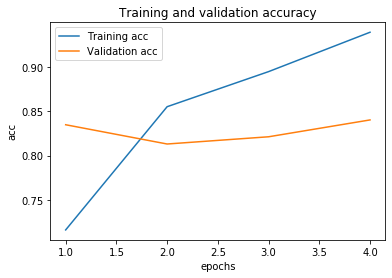

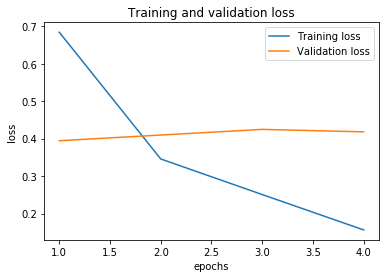

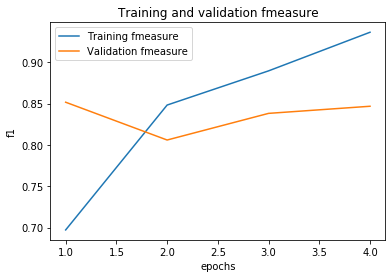

In [69]:
plot_result(history)

In [0]:
#build the model 2
def build_elmo_lstm():
  """ Using Bidirectional-LSTM over elmo-embedding layer """
  inp = layers.Input(shape=(maxlen, 3072,))
  lstm = layers.LSTM(128, dropout=0.3)(inp)
  x = layers.Dense(64, activation='relu')(lstm)
  pred = layers.Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inp, outputs=pred)
  model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
  model.summary()
  return model

In [52]:
elmo_lstm = build_elmo_lstm()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 50, 3072)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               1638912   
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 1,647,233
Trainable params: 1,647,233
Non-trainable params: 0
_________________________________________________________________


In [53]:
# fit the model
history = elmo_lstm.fit(elmo_embedding, label, validation_split=0.1, epochs=4, batch_size=32)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 18s 5ms/step - loss: 0.5683 - acc: 0.7145 - f1: 0.7024 - val_loss: 0.5037 - val_acc: 0.7669 - val_f1: 0.8057
Epoch 2/4
3317/3317 [==============================] - 16s 5ms/step - loss: 0.4324 - acc: 0.8092 - f1: 0.7988 - val_loss: 0.3875 - val_acc: 0.8320 - val_f1: 0.8215
Epoch 3/4
3317/3317 [==============================] - 17s 5ms/step - loss: 0.3532 - acc: 0.8550 - f1: 0.8514 - val_loss: 0.3780 - val_acc: 0.8347 - val_f1: 0.8501
Epoch 4/4
3317/3317 [==============================] - 17s 5ms/step - loss: 0.3067 - acc: 0.8740 - f1: 0.8700 - val_loss: 0.3499 - val_acc: 0.8699 - val_f1: 0.8636


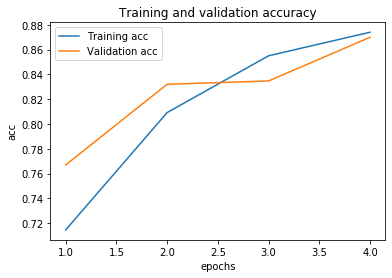

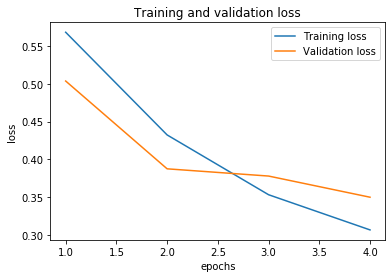

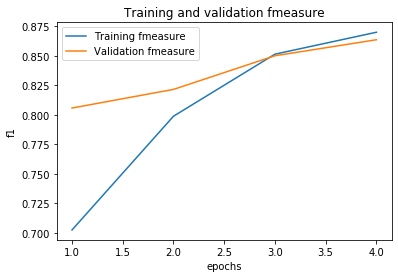

In [54]:
plot_result(history)

In [0]:
def build_elmo_bilstm_attention():
    inp = layers.Input(shape=(maxlen, 3072,))
    # x = layers.Embedding(embedding_dim=3072, weights=[elmo_embedding], trainable=False)(inp)
    x = layers.Bidirectional(layers.LSTM(64, dropout=0.5, return_sequences=True))(inp)
    x = AttentionWithContext()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    pred = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=pred)
    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
    model.summary()
    return model

In [46]:
elmo_bilstm_attention = build_elmo_bilstm_attention()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 50, 3072)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 128)           1606144   
_________________________________________________________________
attention_with_context_1 (At (None, 128)               16640     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 1,631,105
Trainable params: 1,631,105
Non-trainable params: 0
_________________________________________________

In [47]:
# fit the model
history = elmo_bilstm_attention.fit(elmo_embedding, label, validation_split=0.1, epochs=4, batch_size=32)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 36s 11ms/step - loss: 0.5050 - acc: 0.7453 - f1: 0.7406 - val_loss: 0.4203 - val_acc: 0.8347 - val_f1: 0.8138
Epoch 2/4
3317/3317 [==============================] - 36s 11ms/step - loss: 0.3810 - acc: 0.8336 - f1: 0.8300 - val_loss: 0.3764 - val_acc: 0.8293 - val_f1: 0.8231
Epoch 3/4
3317/3317 [==============================] - 35s 10ms/step - loss: 0.3021 - acc: 0.8734 - f1: 0.8691 - val_loss: 0.3506 - val_acc: 0.8509 - val_f1: 0.8561
Epoch 4/4
3317/3317 [==============================] - 35s 11ms/step - loss: 0.2698 - acc: 0.8939 - f1: 0.8907 - val_loss: 0.4146 - val_acc: 0.8347 - val_f1: 0.8533


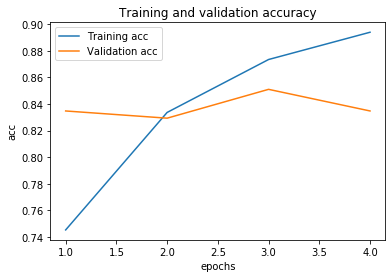

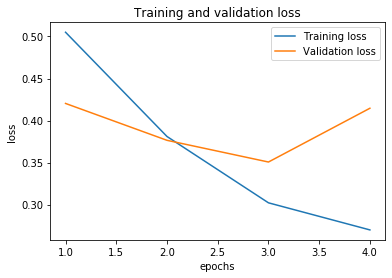

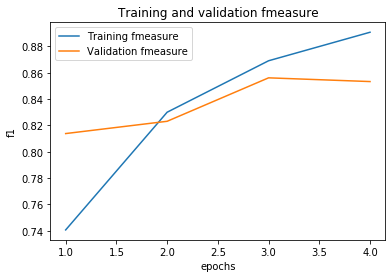

In [48]:
plot_result(history4)